In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

In [2]:
DIESEL_REGULAR_ID = 41726
DIESEL_PREMIUM_ID = 41740

COMMODITIES = ["soybeans", "corn"]

LITERS_FACTOR = 1000

In [3]:
inputs_monthly = pd.read_parquet("../data/processed/inputs_monthly.parquet")
commodities_monthly = pd.read_parquet("../data/processed/commodities_monthly.parquet")

In [4]:
diesel_df = inputs_monthly[
    inputs_monthly["id_articulo"].isin([DIESEL_REGULAR_ID, DIESEL_PREMIUM_ID])
].copy()

In [5]:
diesel_df["diesel_type"] = diesel_df["id_articulo"].map({
    DIESEL_REGULAR_ID: "Diesel Regular",
    DIESEL_PREMIUM_ID: "Diesel Premium"
})

In [6]:
diesel_df = diesel_df.sort_values("year_month")

In [7]:
diesel_df["date"] = diesel_df["year_month"].dt.to_timestamp()

In [10]:
diesel_df["price_usd_1000_lts"] = diesel_df["price_usd_last"] * LITERS_FACTOR

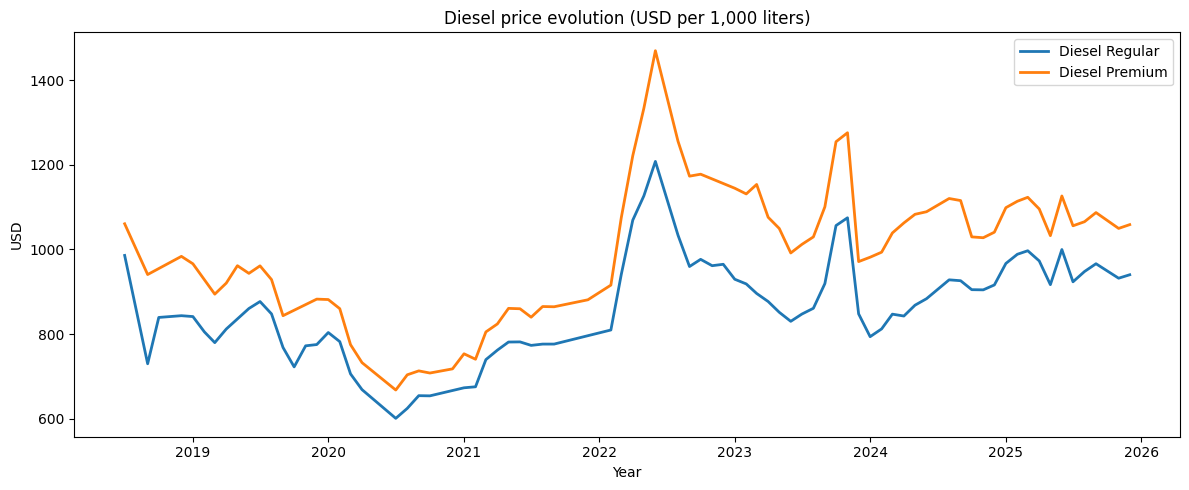

In [11]:
plt.figure(figsize=(12, 5))

for diesel_type in diesel_df["diesel_type"].unique():
    df_plot = (
        diesel_df[diesel_df["diesel_type"] == diesel_type]
        .sort_values("date")
    )

    plt.plot(
        df_plot["date"],
        df_plot["price_usd_1000_lts"],
        label=diesel_type,
        linewidth=2
    )

plt.title("Diesel price evolution (USD per 1,000 liters)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.show()


### Insight intermedio

The evolution of diesel prices in USD shows that, while Regular Diesel and Premium Diesel follow similar general trends, the price difference between them is not constant over time.

There are periods when the premium for Premium Diesel increases significantly, as well as others when prices converge. This suggests that, in addition to the common factors in the energy market, specific elements play a role in the pricing of each product.

Likewise, episodes of greater volatility associated with international shocks are observed in the energy market, where both products react in the same direction, although with different intensity.

In [16]:
START_DATE = pd.Period("2020-01", freq="M")
END_DATE = pd.Period("2025-12", freq="M")

diesel_df_plot = diesel_df[
    (diesel_df["year_month"] >= START_DATE) &
    (diesel_df["year_month"] <= END_DATE)
].copy()


In [17]:
commodities_df = commodities_monthly[
    commodities_monthly["commodity_id"].isin(COMMODITIES)
].copy()

In [18]:
commodities_df = commodities_df[
    (commodities_df["year_month"] >= START_DATE) &
    (commodities_df["year_month"] <= END_DATE)
].copy()

In [19]:
commodities_df = commodities_df.sort_values(
    ["commodity_id", "year_month"]
)

commodities_df.head()

,commodity_id,year_month,price_usd_mean
0,corn,2020-01,153.246136
1,corn,2020-02,145.503147
2,corn,2020-03,141.361909
3,corn,2020-04,130.012156
4,corn,2020-05,120.456803


In [20]:
commodities_df.groupby("commodity_id")["year_month"].nunique()

commodity_id
corn        72
soybeans    72
Name: year_month, dtype: int64

In [30]:
commodities_sel = commodities_monthly[
    commodities_monthly["commodity_id"].isin(COMMODITIES)
].copy()

commodities_sel = commodities_sel.sort_values("year_month")

commodities_sel["date"] = commodities_sel["year_month"].dt.to_timestamp()


In [31]:
commodities_sel.head()

,commodity_id,year_month,price_usd_mean,date
0,corn,2020-01,153.246136,2020-01-01
144,soybeans,2020-01,257.766252,2020-01-01
145,soybeans,2020-02,243.262289,2020-02-01
1,corn,2020-02,145.503147,2020-02-01
2,corn,2020-03,141.361909,2020-03-01


In [32]:
START_DATE = "2020-01"
END_DATE = "2025-12"

diesel_df_plot = diesel_df[
    (diesel_df["year_month"] >= START_DATE) &
    (diesel_df["year_month"] <= END_DATE)
].copy()

commodities_plot = commodities_sel[
    (commodities_sel["year_month"] >= START_DATE) &
    (commodities_sel["year_month"] <= END_DATE)
].copy()


In [33]:
diesel_commodity_df = diesel_df_plot.merge(
    commodities_plot,
    on="year_month",
    how="inner"
)

In [34]:
diesel_commodity_df["tons_per_1000_lts"] = (
    diesel_commodity_df["price_usd_1000_lts"] /
    diesel_commodity_df["price_usd_mean"]
)

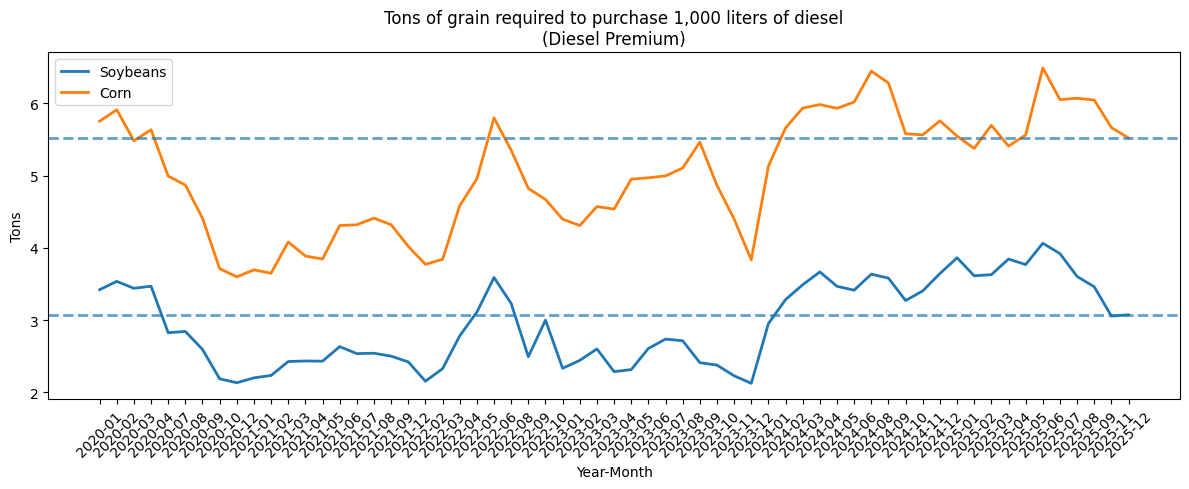

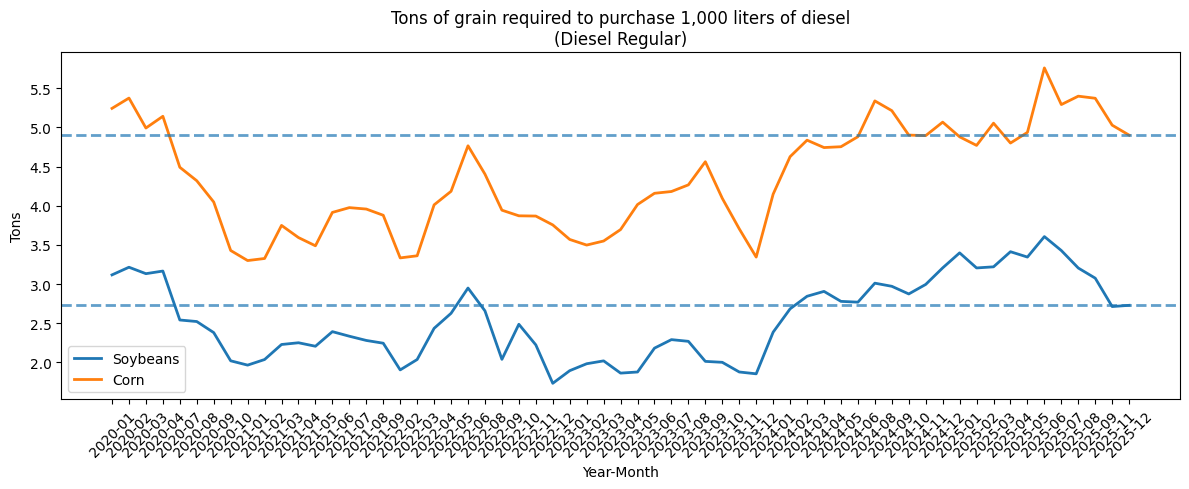

In [35]:
for diesel_type in diesel_commodity_df["diesel_type"].unique():

    df_plot = diesel_commodity_df[
        diesel_commodity_df["diesel_type"] == diesel_type
    ].sort_values("year_month")

    plt.figure(figsize=(12, 5))

    for commodity in COMMODITIES:
        df_c = df_plot[df_plot["commodity_id"] == commodity]

        plt.plot(
            df_c["year_month"].astype(str),
            df_c["tons_per_1000_lts"],
            label=commodity.capitalize(),
            linewidth=2
        )

        last_ratio = df_c["tons_per_1000_lts"].iloc[-1]

        plt.axhline(
            y=last_ratio,
            linestyle="--",
            linewidth=2,
            alpha=0.7,
        )

    plt.title(
        f"Tons of grain required to purchase 1,000 liters of diesel\n({diesel_type})"
    )
    plt.xlabel("Year-Month")
    plt.ylabel("Tons")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



### Insight

During the 2019–2023 period, diesel prices in USD terms remained relatively low compared to agricultural commodities, reflecting domestic price controls and energy market interventions. Following the policy shift in late 2023, diesel prices aligned with international benchmarks, resulting in a higher grain-to-diesel ratio. This indicates a structural deterioration in the purchasing power of agricultural output relative to energy inputs.